In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

%matplotlib inline

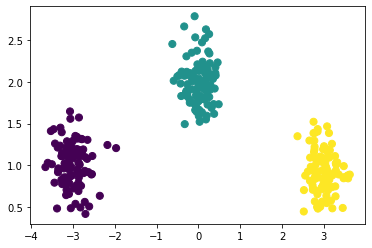

In [40]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300, cluster_std=.25, centers=np.array([(-3, 1), (0, 2), (3, 1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

In [41]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0, .., (n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        :param estimator : binary base classifier used
        :param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        :param X: array-like, shape = [n_samples, n_features], input data
        :param y: array-like, shape = [n_samples,] class labels
        :return returns self
        """
        num_ins = len(X)
        masks = np.vstack([y==i for i in range(self.n_classes)])
        labels = np.zeros(num_ins)
        for i in range(self.n_classes):
            labels[masks[i]] = 1
            labels[~masks[i]] = 0
            self.estimators[i].fit(X, labels)
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        :param X : array-like, shape = [n_samples, n_features] input data

        :return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")

        num_ins = len(X)
        confidence = np.zeros([num_ins, self.n_classes])
        for i in range(self.n_classes):
            confidence[:, i] = self.estimators[i].decision_function(X)
        return confidence
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        confidence = self.decision_function(X)
        prediction = np.max(confidence, axis=1)
        return prediction


Coeffs 0
[[-1.05853544 -0.90294946]]
Coeffs 1
[[0.35117439 0.39494405]]
Coeffs 2
[[ 0.89163962 -0.82600343]]


D:\anaconda3\envs\Python_ML_Alg\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


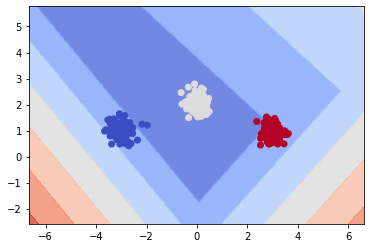

In [59]:
# Here we test the OneVsAllClassifier

from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200, max_iter=3000)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X, y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_)  # Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02   # step size in the mesh
x_min, x_max = min(X[:, 0]) - 3, max(X[:,0]) + 3
y_min, y_max = min(X[:, 1]) - 3, max(X[:,1]) + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.savefig('../figures/hw6/on_vs_all_svm.png')

# from sklearn import metrics
# metrics.confusion_matrix(y, clf_onevsall.predict(X))

Multiclass SVM

In [52]:

def zeroOne(y, a) :
    """
    Computes the zero-one loss.
    :param y: output class
    :param a: predicted class
    :return 1 if different, 0 if same
    """
    return int(y != a)


def feature_map(X, y, num_classes) :
    """
    Computes the class-sensitive features.
    :param X: array-like, shape = [n_samples, n_inFeatures] or [n_inFeatures,], input features for input data
    :param y: a target class (in range 0, .., num_classes-1)
    :return array-like, shape = [n_samples, num_out_features], the class sensitive features for class y
    """
    # The following line handles X being a 1d-array or a 2d-array
    num_samples, num_in_feat = (1, X.shape[0]) if len(X.shape) == 1 else (X.shape[0], X.shape[1])
    num_out_feat = num_classes * num_in_feat
    feat_by_class = np.zeros([num_samples, num_out_feat])
    for i in range(num_samples):
        feat_by_class[i, y*num_in_feat:(y+1)*num_in_feat] = X[i]
    return feat_by_class


def subgradient_descent(X, y, num_out_feat, subgd, eta=0.1, T=10000):
    """
    Runs subgradient descent, and outputs resulting parameter vector.
    :param X: array-like, shape = [n_samples,n_features], input training data
    :param y: array-like, shape = [n_samples,], class labels
    :param num_out_feat: number of class-sensitive features
    :param subgd: function taking x,y and giving subgradient of objective
    :param eta: learning rate for SGD
    :param T: maximum number of iterations
    :return: vector of weights
    """
    num_samples = X.shape[0]
    index = np.arange(num_samples)
    w = np.zeros(num_out_feat)
    for _ in range(T):
        np.random.shuffle(index)
        for i in range(num_samples):
            subgrad = subgd(X[index[i]], y[index[i]], w)
            w -= eta*subgrad
    return w


class MulticlassSVM(BaseEstimator, ClassifierMixin):
    """
    Implements a Multiclass SVM estimator.
    """
    def __init__(self, lam=1.0, num_classes=3, Delta=zeroOne, Psi=feature_map):
        """
        Creates a MulticlassSVM estimator.
        @param num_out_feat: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        """
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X, y : Psi(X, y, num_classes)
        self.fitted = False
    
    def subgradient(self, x, y, w):
        """
        Computes the subgradient at a given data point (x, y)
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given (x, y, w)
        """
        diff_feat = np.vstack([self.Psi(x, i) for i in range(self.num_classes)])
        diff_feat -= diff_feat[y]
        margins = np.asarray([self.Delta(y, i) for i in range(self.num_classes)])
        idx = np.argmax(diff_feat@w + margins)
        return diff_feat[idx] + 2*self.lam*w
        
    def fit(self, X, y, eta=0.1, T=10000):
        """
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        """
        num_out_feat = self.num_classes*X.shape[1]
        self.coef_ = subgradient_descent(X, y, num_out_feat, self.subgradient, eta, T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        """
        Returns the score on each input for each class. Assumes
        that fit has been called.
        :param X : array-like, shape = [n_samples, n_inFeatures]
        :return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        num_ins, num_in_feat = X.shape
        scores = np.zeros([num_ins, self.num_classes])
        for i in range(self.num_classes):
            scores[:, i] = X @ self.coef_[i*num_in_feat:(i+1)*num_in_feat]

        return scores

    def predict(self, X):
        """
        Predict the class with the highest score.
        :param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        :return array-like, shape = [n_samples,], class labels predicted for each data point
        """
        scores = self.decision_function(X)
        classes = np.argmax(scores, axis=1)
        return classes

w:
[-0.26771266 -0.26771266  0.19974649  0.19974649  0.06796618  0.06796618]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0, 100,   0]], dtype=int64)

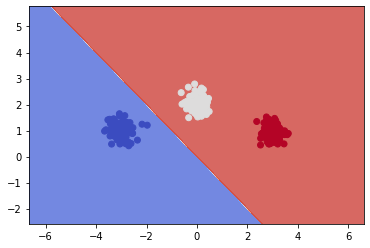

In [60]:
# the following code tests the MulticlassSVM and sgd
# will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(lam=1)
est.fit(X, y, T=2000)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.savefig('../figures/hw6/multiclass_svm.png')

from sklearn import metrics

metrics.confusion_matrix(y, est.predict(X))

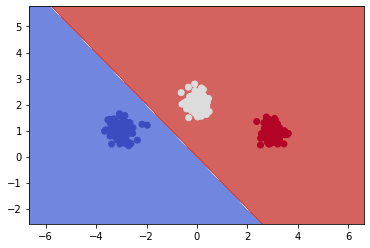

In [55]:
# This is used as a baseline.

from sklearn.multiclass import OneVsRestClassifier
base_clf = svm.LinearSVC()
multi_clf = OneVsRestClassifier(base_clf, n_jobs=-1)
multi_clf.fit(X, y)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


In [57]:
print(multi_clf.n_classes_)
np.unique(Z)

3


array([0, 2], dtype=int64)